# Our datasets benchmark

In [1]:
import pandas as pd
import os 
import sys
sys.path.append('/disk1/ariane/vscode/enzyme-tk/enzymetk/')
from steps.sequence_search_blast import BLAST
from steps.save_step import Save

swissprot = pd.read_csv('swissprot.tsv', sep='\t') 
def annotate_residue_from_uniprot(df):
    # Organise the active sites of these guys to be better
    active_sites = []
    active_site_residue_counts = []
    x = 0
    for act_site in df['Active site'].values:
        sites = []
        if isinstance(act_site, str):
            act_site = act_site.replace(" ", '')
            for act in act_site.split('ACT_SITE'):
                try:
                    sites.append(int(act.split(';')[0].replace(" ", '')) - 1) # Need to subtract 1 to make it fit with the fact that python is 0 encoded lol
                except:
                    x = 1
        if len(sites) != 0:
            active_sites.append('|'.join([str(s) for s in sites]))
            active_site_residue_counts.append(len(sites))
        else:
            active_sites.append('None')
            active_site_residue_counts.append(0)
    df['Residue'] = active_sites
    df['active_site_residue_counts'] = active_site_residue_counts
    return df
    
swissprot = annotate_residue_from_uniprot(swissprot)
swissprot = swissprot[swissprot['active_site_residue_counts'] > 0]
training_ids = set(pd.read_csv('Structural_ID_benchmark_training_set.txt', header=None)[0].values)
test_ids = set(pd.read_csv('0.3_Structural_ID_benchmark.txt', header=None)[0].values)
test_df = swissprot[swissprot['Entry'].isin(test_ids)]
training_df = swissprot[swissprot['Entry'].isin(training_ids)]


In [2]:
test_df.to_csv('swissprot_test_set.csv', index=False)

In [3]:
ec3 = []
for e in swissprot['EC number'].values:
    e3 = False
    if isinstance(e, str):
        for ec in e.split(';'):
            if e[:4] == '3.1.':
                e3 = True
    ec3.append(e3)
swissprot['esterase'] = ec3
swissprot['esterase'].value_counts()
swissprot[swissprot['esterase'] == True].to_csv('esterase_swissprot.csv', index=False)

In [6]:

# Remove from SwissProt
# Now we're going to save this as a fasta file 
fasta_label = f'swissprot_with_active_site_seqs_SquidlyBenchmark.fasta'
with open(fasta_label, 'w+') as fout:
    for entry, seq in training_df[['Entry', 'Sequence']].values:
        if entry not in test_ids:
            fout.write(f'>{entry}\n{seq}\n')
        else:
            # Just making double sure no contamination
            print(f"{entry} in training set?")
# Do blast on this dataset 
# This should be where you downloaded the data from zotero, there is a folder in there called AS_inference
# This contains the models and the data needed to run the tool
id_col = 'Entry'
seq_col = 'Sequence'
test_df << (BLAST(id_col, seq_col, database=fasta_label, args=['--ultra-sensitive']) >> Save(f'blast/Squidly_BLAST.pkl'))

diamond v2.1.11.165 (C) Max Planck Society for the Advancement of Science, Benjamin Buchfink, University of Tuebingen
Documentation, support and updates available at http://www.diamondsearch.org
Please cite: http://dx.doi.org/10.1038/s41592-021-01101-x Nature Methods (2021)

#CPU threads: 384
Scoring parameters: (Matrix=BLOSUM62 Lambda=0.267 K=0.041 Penalties=11/1)
Database input file: swissprot_with_active_site_seqs_SquidlyBenchmark.fasta
Opening the database file...  [0.001s]
Loading sequences...  [0.008s]
Masking sequences...  [0.032s]
Writing sequences...  [0.001s]
Hashing sequences...  [0s]
Loading sequences...  [0s]
Writing trailer...  [0s]
Closing the input file...  [0s]
Closing the database file...  [0.001s]

Database sequences  5357
  Database letters  2224264
     Database hash  d963bdcfc7da93f07581dee9ae3e9a65
        Total time  0.046000s
diamond v2.1.11.165 (C) Max Planck Society for the Advancement of Science, Benjamin Buchfink, University of Tuebingen
Documentation, supp

              0       1     2    3    4   5   6    7    8    9   \
0     A0A2D0TC04  O14638  64.6  826  283   7  10  829   53  875   
1     A0A2D0TC04  P97675  63.0  830  299   6   1  825   45  871   
2     A0A2D0TC04  P22413  53.5  826  367  10   8  825  105  921   
3     A0A2D0TC04  P06802  49.1  827  401  11   8  825   87  902   
4     A0A2D0TC04  Q64610  45.8  853  407  10  10  829   57  887   
...          ...     ...   ...  ...  ...  ..  ..  ...  ...  ...   
2223      Q9I2A8  P09110  43.7  391  203   5   3  387   37  416   
2224      Q9I2A8  O53871  38.6  415  216   7   2  392    3  402   
2225      Q9I2A8  I6XHI4  41.5  390  202   9   5  382    5  380   
2226      Q9I2A8  P76503  33.6  422  242   7   4  390   15  433   
2227      Q9I2A8  P55084  31.7  423  248  10   1  388   51  467   

                 10      11  
0      0.000000e+00  1054.0  
1      0.000000e+00  1053.0  
2     1.290000e-298   843.0  
3     1.320000e-280   796.0  
4     7.310000e-254   728.0  
...            

 [0.017s]
Deallocating memory...  [0s]
Deallocating buffers...  [0.001s]
Clearing query masking...  [0s]
Computing alignments...  [0.073s]
Deallocating reference...  [0s]
Loading reference sequences...  [0s]
Deallocating buffers...  [0s]
Deallocating queries...  [0s]
Loading query sequences...  [0s]
Closing the input file...  [0s]
Closing the output file...  [0s]
Closing the database...  [0s]
Cleaning up...  [0s]
Total time = 10.126s
Reported 2228 pairwise alignments, 2228 HSPs.
231 queries aligned.


,query,target,sequence identity,length,mismatch,gapopen,query start,query end,target start,target end,e-value,bitscore
0,A0A2D0TC04,O14638,64.6,826,283,7,10,829,53,875,0.000000e+00,1054.0
1,A0A2D0TC04,P97675,63.0,830,299,6,1,825,45,871,0.000000e+00,1053.0
2,A0A2D0TC04,P22413,53.5,826,367,10,8,825,105,921,1.290000e-298,843.0
3,A0A2D0TC04,P06802,49.1,827,401,11,8,825,87,902,1.320000e-280,796.0
4,A0A2D0TC04,Q64610,45.8,853,407,10,10,829,57,887,7.310000e-254,728.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2223,Q9I2A8,P09110,43.7,391,203,5,3,387,37,416,2.400000e-82,256.0
2224,Q9I2A8,O53871,38.6,415,216,7,2,392,3,402,1.480000e-67,217.0
2225,Q9I2A8,I6XHI4,41.5,390,202,9,5,382,5,380,1.390000e-64,209.0
2226,Q9I2A8,P76503,33.6,422,242,7,4,390,15,433,9.220000e-58,192.0


In [7]:
len(set(test_ids) & set(training_ids))

0

In [8]:
len(set(test_ids))

243

In [9]:
import pandas as pd
test_ids = set(pd.read_csv('0.3_Structural_ID_benchmark.txt', header=None)[0].values)


In [10]:
test_df = swissprot[swissprot['Entry'].isin(test_ids)]


In [11]:

blast_df = pd.read_pickle(f'blast/Squidly_BLAST.pkl')
blast_df = blast_df.sort_values(by='sequence identity', ascending=False)
blast_df.drop_duplicates('query', inplace=True)
# Then join up with all df
blast_df.set_index('query', inplace=True)
test_df.set_index('Entry', inplace=True)
test_df['From'] = test_df.index
test_df = test_df.join(blast_df, how='left')
uniprot_id_to_seq = dict(zip(swissprot.Entry, swissprot.Sequence))
for name, seq, uniprot in test_df[['From', 'Sequence', 'target']].values:
    fin = f'msa/{uniprot}_{name}.fa'
    with open(fin, 'w+') as fout:
        fout.write(f'>{uniprot}\n{uniprot_id_to_seq.get(uniprot)}\n')
        fout.write(f'>{name}\n{seq}')
    # Now run clustalomega
    os.system(f'clustalo --force -i {fin} -o {fin.replace(".fa", ".msa")}')

/tmp/ipykernel_4060528/2732617263.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['From'] = test_df.index


A1L259 Q9LVM5 H L
G8JZS4 Q8A6L0 D G
O34525 P08395 K -
O49523 A8PUY1 H E
O57712 Q9V1A5 D -
P15067 Q55088 E Q
P15807 P25924 D K
P15807 P25924 K Q
P23908 Q96KN2 E D
P43378 P18433 C -
P54493 P09391 S G
Q6PW77 Q0PCD7 Y W
Q8ZL58 Q44244 K D
Q988D4 P22862 D S
Q988D4 P22862 H E
Q9I194 Q9L5D6 E T
A9WC36 O06543 H S
A9WC36 O06543 D -
O75715 P22352 U C
P0C2S1 P0C2S5 - Q
P0C2S1 P0C2S5 - G
P0C2S1 P0C2S5 - H
P0C2S1 P0C2S5 - T
P0C2S1 P0C2S5 E Y
P0C2S1 P0C2S5 D -
P16218 Q70DK5 D -
P16218 Q70DK5 D Y
P39130 Q2YLR9 H N
Q9CYR6 Q5NII8 S -
Q9KN42 Q9I6M7 E H
P39824 P00808 E D
Q4MV79 P15917 E -
198 32 13 0.8569958847736625


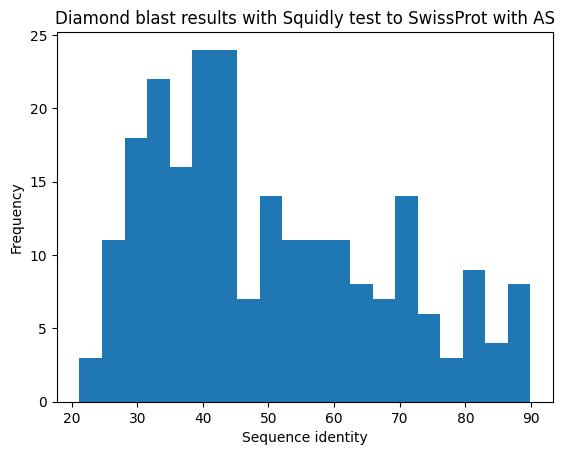

In [26]:
from Bio import AlignIO
import matplotlib.pyplot as plt
uniprot_id_to_active_site = dict(zip(swissprot['Entry'], swissprot['Residue']))
import seaborn as sns
import numpy as np

predicted_active_sites = {}
missing = 0
for query, uniprot in test_df[['From', 'target']].values:
    try:
        fin = f'msa/{uniprot}_{query}.msa'
        # Read with bioseq
        # Read the alignment
        active_sites = [int(x) for x in uniprot_id_to_active_site.get(uniprot).split('|')]
        alignment = AlignIO.read(fin, 'fasta')
        # get the existing one and then calculate the position gapped
        records = {}
        for record in alignment:
            records[record.id] = record.seq
        # Now get the active site
        position_count = 0
        active_pred = []
        query_seq = records[query]
        query_count = 0
        for i, v in enumerate(records[uniprot]):
            if position_count in active_sites:
                if query_count < len(query_seq.replace('-', '')):
                    active_pred.append(query_count)
                if query_seq[i] != v:
                    print(query, uniprot, v, query_seq[i])
            if v != '-':
                position_count += 1
            if query_seq[i] != '-' and query_seq[i] != ' ':
                query_count += 1
    
        predicted_active_sites[query] = '|'.join([str(s) for s in active_pred])
        # Now we can just add on the
    except:
        missing += 1

test_df['BLAST_residues'] = [predicted_active_sites.get(label) for label in test_df['From'].values]
test_df['True_residues'] = [uniprot_id_to_active_site.get(label) for label in test_df['From'].values]

# Check the agreement:
agree, disagree, none_ = 0, 0, 0
percent_aggree = []
to_check = []
labels = []
for seq_label, res_sq, res_blast in test_df[['From', 'True_residues', 'BLAST_residues']].values:
    if res_sq != res_blast:
        to_check.append(seq_label)
        if not res_blast:
            none_ += 1
            percent_aggree.append(0)
            labels.append('Missing')
        else:
            # Check the % agree 
            res_sq = res_sq.split('|')
            res_blast = res_blast.split('|')
            percent_aggree.append(len(set(res_sq) & set(res_blast))/max(len(res_sq), len(res_blast)))
            disagree += 1
            labels.append('Difference')
    else:
        percent_aggree.append(1)
        labels.append('Agree')
        agree += 1
print(agree, disagree, none_, np.mean(percent_aggree))
test_df['BLAST_labels'] = labels
#sns.histplot(test_df, x='sequence identity', hue='BLAST_labels',  hue_order=['Missing', 'Difference', 'Agree'])
plt.hist(test_df['sequence identity'].values, bins=20) #[[l == 'Agree' for l in labels]], bins=10, color='orange', alpha=0.5)
#plt.hist(test_df['sequence identity'].values[[l == 'Difference' for l in labels]], bins=10, color='green', alpha=0.5)
#plt.hist(test_df['sequence identity'].values[[l == 'Missing' for l in labels]], bins=1, color='blue', alpha=0.5)

plt.title('Diamond blast results with Squidly test to SwissProt with AS')
plt.ylabel('Frequency')
plt.xlabel('Sequence identity')
plt.savefig(f'Figures/DiamondBlast_histogram_Squildy.svg')

In [13]:
test_df['sequence identity'].values[[l == 'Missing' for l in labels]]

array([ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan, 31.5,
        nan,  nan])

In [16]:
test_df['BLAST_labels'].value_counts()

Agree         198
Difference     32
Missing        13
Name: BLAST_labels, dtype: int64

In [18]:
squidly_pred = pd.read_pickle('squidly/squidly_as_pred_swissprot_test_set.pkl')
squidly_pred.set_index('label', inplace=True)
test_df = test_df.join(squidly_pred, how='left')

In [19]:
# Read in Squidly now as well
from Bio import AlignIO
import matplotlib.pyplot as plt
uniprot_id_to_active_site = dict(zip(swissprot['Entry'], swissprot['Residue']))

predicted_active_sites = {}
missing = 0
# Check the agreement:
agree, disagree, none_ = 0, 0, 0
percent_aggree = []
to_check = []
for seq_label, res_sq, res_squidly, res_blast in test_df[['From', 'True_residues', 'Squidly_CR_Position', 'BLAST_residues']].values:
    if res_sq != res_squidly:
        to_check.append(seq_label)
        if not res_squidly:
            none_ += 1
            percent_aggree.append(0)
        else:
            # Check the % agree 
            res_sq = res_sq.split('|')
            res_squidly = res_squidly.split('|')
            percent_aggree.append(len(set(res_sq) & set(res_squidly))/max(len(res_sq), len(res_squidly)))
            disagree += 1
    else:
        percent_aggree.append(1)
        agree += 1
print(agree, disagree, none_, np.mean(percent_aggree))

139 100 4 0.7870370370370371


In [25]:
# Read in Squidly now as well
from Bio import AlignIO
import matplotlib.pyplot as plt
uniprot_id_to_active_site = dict(zip(swissprot['Entry'], swissprot['Residue']))

predicted_active_sites = {}
missing = 0
# Check the agreement:
agree, disagree, none_ = 0, 0, 0
percent_aggree = []
to_check = []
for seq_label, res_sq, res_squidly, res_blast in test_df[['From', 'True_residues', 'Squidly_CR_Position', 'BLAST_residues']].values:
    if res_sq != res_blast or res_sq != res_squidly:
        to_check.append(seq_label)
        if not res_blast and not res_squidly:
            none_ += 1
            percent_aggree.append(0)
        else:
            # Check the % agree 
            res_sq = res_sq.split('|')
            if res_blast:
                res_blast = res_blast.split('|')
            else:
                res_blast = []
            if res_squidly:
                res_squidly = res_squidly.split('|')
            else:
                res_squidly = []
            if len(res_blast) > 0 and len(res_squidly) > 0:
                print(res_sq, res_blast, res_squidly)
                res_squidly = set(res_squidly) & set(res_blast)
            elif len(res_blast) > 0:
                res_squidly = res_blast
            if not res_squidly:
                none_ += 1
                percent_aggree.append(0)
            else:
                percent_aggree.append(len(set(res_sq) & set(res_squidly))/max(len(res_sq), len(res_squidly)))
                disagree += 1
    else:
        percent_aggree.append(1)
        agree += 1
print(agree, disagree, none_)

['338'] ['338'] ['109', '338']
['66'] ['54'] ['66']
['146', '151'] ['146', '151'] ['146', '148', '151']
['531'] ['468', '531'] ['466', '506', '531']
['271'] ['271', '299', '331'] ['271', '299', '331']
['146', '198'] ['0', '146'] ['146', '168', '198']
['96', '257', '363', '387'] ['96', '363', '387'] ['96', '257', '363', '387']
['235', '235', '301', '338'] ['235', '301', '364'] ['235', '301', '338']
['326'] ['0'] ['326']
['361'] ['361'] ['348', '361']
['151', '157'] ['151'] ['151']
['168', '390'] ['168', '390'] ['168', '172', '390']
['148', '208'] ['148', '208'] ['71', '148', '185', '208']
['280'] ['280'] ['85', '280']
['335', '370'] ['335', '364'] ['335', '370']
['81', '143'] ['81', '142'] ['81', '143', '168']
['61', '64', '305'] ['61', '64', '305'] ['60', '61', '64', '305']
['99', '155'] ['99', '155'] ['60', '99', '155', '189', '273']
['217'] ['246'] ['246', '313']
['254', '288'] ['254', '288'] ['165', '254', '288', '462']
['404', '407', '471'] ['404', '407', '471'] ['404', '407', '471

In [21]:
np.mean(percent_aggree)

0.8943758573388202

In [22]:
import numpy as np
np.mean(percent_aggree)

0.8943758573388202